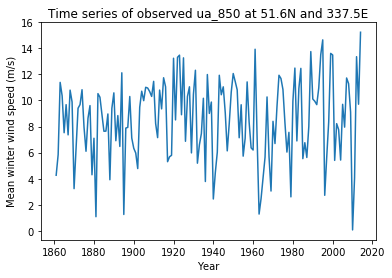

((array([199]),), (array([3039]),), 'Iceland')
((array([449]),), (array([2972]),), 'Azores')


In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc 

ds_ws = xr.open_dataset("/rds/general/project/circulates/live/data/20CR/ua850_v2c_185101-201412.nc")
ds_pressure = xr.open_dataset("/rds/general/project/circulates/live/data/20CR/ps_v2c_185101-201412.nc")

#the chosen grid point is [time, 0, 13, 120] -> [time, 850.0, 51.6 N, 337.5 E]
#to access year use .dt.year
#print(type(ds_ua850.time[1].dt.year))
local_speed = np.array([])
for i in range(10, 164): #February, 2014 is 1957
    local_speed = np.append(local_speed, [np.average([float(ds_ws.ua[12*i-1, 0, 13, 120]), \
                                         float(ds_ws.ua[12*i, 0, 13, 120]), \
                                       float(ds_ws.ua[12*i+1, 0, 13, 120])])])
    
plt.plot(ds_ws.time[120:1957:12].dt.year, local_speed)
plt.title('Time series of observed ua_850 at 51.6N and 337.5E')
plt.ylabel('Mean winter wind speed (m/s)')
plt.xlabel('Year')
plt.show()

'''Filling in the unfilled coordinates''' 
#Creating equally spaced longitude array that includes real coordinates
lonss = np.empty([128*25])
for i in range(0, 128):
    if i == 127:
        lonss[(i*25):(i+1)*25] = np.linspace(ds_ws.lon[i], 360.0, 26)[0:-1] #interpolating up to 360
    else:
        lonss[(i*25):(i+1)*25] = np.linspace(ds_ws.lon[i], ds_ws.lon[i+1], 26)[0:-1]

#Creating equally spaced latitude array that includes real coordinates
latss = np.empty([31*25])
for i in range(0, 31):
    latss[(i*25):(i+1)*25] = np.linspace(ds_ws.lat[i], ds_ws.lat[i+1], 26)[0:-1]
latss = np.append(latss, ds_ws.lat[31])

#latss 65.68921234 - iceland
#lonss 341.8875 - iceland
#latss 37.78471054 - azores
#lonss 334.35 - azores 
latss = np.round(latss, 8)
print(np.where(latss == 65.68921234), np.where(lonss == 341.8875), 'Iceland')
print(np.where(latss == 37.78471054), np.where(lonss == 334.35), 'Azores')


In [31]:
ds_ws.time[:]


<xarray.DataArray 'time' (time: 1968)>
array(['1851-01-01T00:00:00.000000000', '1851-02-01T00:00:00.000000000',
       '1851-03-01T00:00:00.000000000', ..., '2014-10-01T00:00:00.000000000',
       '2014-11-01T00:00:00.000000000', '2014-12-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1851-01-01 1851-02-01 ... 2014-12-01
Attributes:
    standard_name:  time
    long_name:      Time
    axis:           T

(3200, 776, (776, 3200))


<a list of 13 text.Text objects>

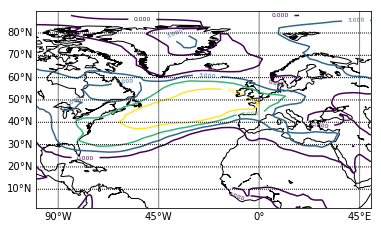

In [4]:
import os
os.environ["PROJ_LIB"] = "/rds/general/user/ib719/home/anaconda3/envs/test1/share/proj"
from mpl_toolkits.basemap import Basemap
ds_ua850 = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ws_interpolated.nc")

map = Basemap(projection='cyl',llcrnrlon=-100.,llcrnrlat=1.39,urcrnrlon=50.0,urcrnrlat=90.,resolution='c') 
#map = Basemap(projection='cyl',llcrnrlon=-180.,llcrnrlat=1.39,urcrnrlon=180.0,urcrnrlat=90.,resolution='c') 
# projection, lat/lon extents and resolution of polygons to draw
# resolutions: c - crude, l - low, i - intermediate, h - high, f - full
map.drawcoastlines()
map.drawparallels(np.arange(10, 81, 10), labels = [1,0,0,0])
map.drawmeridians(np.arange(-90, 46, 45), labels = [0,0,0,1])
ua = np.array(ds_ua850.value[2])
#ua = np.transpose(np.array(ua))
clevs = np.arange(0, 10, 3)
print(len(lonss), len(latss), ua.shape)

x, y = np.meshgrid(lonss, latss)
#cs = map.contour(x, y, np.roll(ua[:, :], shift = -1600, axis = 1), clevs, colour = 'b')
cs = map.contour(x, y, ua[:, :], clevs, colour = 'b', latlon = 1)
#print(lonss-180)

#x, y = np.meshgrid(ds_ws.lon[:], ds_ws.lat[:])
#cs = map.contour(x, y, ds_ws.ua[0, 0, :, :], clevs, colour = 'b', latlon = 1)

#arr = np.random.random((7,4))
#clevs2 = np.array([0.1, 0.3, 0.5])
#x, y = np.meshgrid(np.array([300.0, 301.0, 302.0, 303.0]), np.array([10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0]))
#cs = map.contour(x-180, y, arr[:, :], clevs2, colour = 'b', latlon = 1)
plt.clabel(cs, fontsize=6, inline=2)

In [11]:
import time as tm
import scipy as sp
from scipy import signal 
import netCDF4 as nc
import numpy as np 
 
'''Creating a new windspeed file'''
start_time = tm.time()
old_lons = np.append(np.array(ds_ws.lon[:]), 360.0) #interpolating up to 360

path = "/rds/general/user/ib719/home/UROP_2021/ws_interpolated2.nc"
ds_ua850 = nc.Dataset(path, 'w', format = 'NETCDF4')
time = ds_ua850.createDimension('time', 1968)
lat = ds_ua850.createDimension('lat', 31*25+1)
lon = ds_ua850.createDimension('lon', 128)

times = ds_ua850.createVariable('time', np.float32, ('time',))
lats = ds_ua850.createVariable('lat', np.float32, ('lat',))
lons = ds_ua850.createVariable('lon', np.float32, ('lon',))
value = ds_ua850.createVariable('value', np.float32, ('time', 'lat', 'lon',))
value.units = 'm/s'
times[:] = np.array(ds_ws.time)
lons[:] = np.array(ds_ws.lon)
lats[:] = latss

for i in range(0,1968):
    ds = ds_ws.isel(time=i).isel(level=0)
    values = ds.ua
    value[i,:,:] = sp.interpolate.griddata(np.array(ds_ws.lat), values, latss , method='cubic')

ds_ua850.close()

print("Total time: --- %s seconds ---" % (tm.time() - start_time))

Total time: --- 59.8579838276 seconds ---


In [18]:
import time as tm
import scipy as sp
from scipy import signal 
import netCDF4 as nc
import numpy as np 

start_time = tm.time()
vals = np.empty([1968, 3, 3])

path_ic = "/rds/general/user/ib719/home/UROP_2021/ps_interpolated.nc"
ps_ic = nc.Dataset(path_ic, 'w', format = 'NETCDF4')
time = ps_ic.createDimension('time', 1968)
lat = ps_ic.createDimension('lat', 776)
lon = ps_ic.createDimension('lon', 128)

times = ps_ic.createVariable('time', np.float32, ('time',))
lats = ps_ic.createVariable('lat', np.float32, ('lat',))
lons = ps_ic.createVariable('lon', np.float32, ('lon',))
value = ps_ic.createVariable('value', np.float32, ('time', 'lat', 'lon',))
value.units = 'm/s'
times[:] = ds_pressure.time[:]
lats[:] = latss
lons[:] = ds_pressure.lon[:]

'''Interpolating surface pressure'''
for i in range(0,1968):
    ds = ds_pressure.isel(time=i)
    values = ds.ps
    value[i,:,:] = sp.interpolate.griddata(ds_ws.lat[:], values, latss[:] , method='cubic')

ps_ic.close()

In [29]:
i = 40
ps_new = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ps_interpolated.nc")
ps_iceland = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ps_interpolated.nc")

#print(ps_new.lat[440:500])
azores_ps = np.average(ps_new.value[(12*i-1):(12*i+2), 199, 119]) # Azores DJF
iceland_ps = np.average(ps_iceland.value[(12*i-1):(12*i+2), 449, 121])

azores_before = np.average(ds_pressure.ps[(12*i-1):(12*i+2), 18, 119])
iceland_before = np.average(ds_pressure.ps[(12*i-1):(12*i+2), 8, 121])

print('azores:', (azores_ps-azores_before)/azores_before)
print('iceland:', (iceland_ps-iceland_before)/iceland_before)


<xarray.DataArray 'lat' (lat: 60)>
array([ 38.789314,  38.677689,  38.566067,  38.454445,  38.342823,  38.231201,
        38.119579,  38.007954,  37.896332,  37.78471 ,  37.673088,  37.561466,
        37.449844,  37.338219,  37.226597,  37.114975,  37.003353,  36.891731,
        36.780106,  36.668484,  36.556862,  36.44524 ,  36.333618,  36.221992,
        36.110371,  35.998749,  35.887127,  35.775505,  35.663879,  35.552258,
        35.440636,  35.329014,  35.217392,  35.105766,  34.994144,  34.882523,
        34.770901,  34.659275,  34.547653,  34.436031,  34.324406,  34.212784,
        34.101162,  33.989536,  33.877914,  33.766293,  33.654667,  33.543045,
        33.431423,  33.319801,  33.208176,  33.096554,  32.984932,  32.873306,
        32.761684,  32.650063,  32.538437,  32.426815,  32.315193,  32.203568], dtype=float32)
Coordinates:
  * lat      (lat) float32 38.7893 38.6777 38.5661 ... 32.4268 32.3152 32.2036
('azores:', -0.021264946)
('iceland:', 0.048407014)


In [54]:
'''Old version'''
import time as tm
import scipy as sp
from scipy import signal 
import netCDF4 as nc
import numpy as np 

#latss 65.68921234 - iceland 24 (old - 8)
#lonss 341.8875 - iceland 39 (old - 121)
#latss 37.78471054 - azores 24 (old - 18)
#lonss 334.35 - azores 22 (old - 119)

start_time = tm.time()

ds_ua850 = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ws_interpolated2.nc")
ps_inter = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ps_interpolated.nc")

ds_ua850['time'] = ds_ws.time
ds_ua850['lat'] = latss
ds_ua850['lon'] = np.array(ds_ws.lon[:])
    
'''Defining useful terms'''
lon_ws_D = np.empty([128])
lon_ws_F = np.empty([128])
lon_ws_J = np.empty([128])
lat_ws_D = np.empty([776])  
lat_ws_J = np.empty([776])  
lat_ws_F = np.empty([776])

jet_strength = np.empty([154])
jet_latitude = np.empty([154])
NAO_index = np.empty([154])
header_param = "Year\t\tLatitude\tStrength\tNAO_index"

'''Winter mean NetCDF file'''
path = "/rds/general/user/ib719/home/UROP_2021/ws_winter.nc"
avg_ws = nc.Dataset(path, 'w', format = 'NETCDF4')
time = avg_ws.createDimension('time', 154)
lat = avg_ws.createDimension('lat', 776)
lon = avg_ws.createDimension('lon', 128)

times = avg_ws.createVariable('time', np.float32, ('time',))
lats = avg_ws.createVariable('lat', np.float32, ('lat',))
lons = avg_ws.createVariable('lon', np.float32, ('lon',))
value = avg_ws.createVariable('value', np.float32, ('time', 'lat', 'lon',))
value.units = 'm/s'
times[:] = np.arange(1861, 2015)
lats[:] = latss
lons[:] = ds_ws.lon[:]

for i in range(10, 164): # Number of years from 1861 to 2014
    for j in range(0, 776): # Latitude points from 87.9d N to 1.4dN
        for k in range(0, 128): # Longitude points from 0 E (300.9d E) to 357.2d E 
            # Longitude array of mean winter ws at a j-th latitude
            lon_ws_D[k] = ds_ua850.value[(12*i-1), j, k] #removed value
            lon_ws_J[k] = ds_ua850.value[(12*i), j, k]
            lon_ws_F[k] = ds_ua850.value[(12*i+1), j, k]
            value[i-10, j, k] = np.average([ds_ua850.value[(12*i-1):(12*i+2), j, k]]) # averaged winter speeds
        lat_ws_D[j] = np.mean(lon_ws_D) # Latitude array of longitudinal monthly values
        lat_ws_J[j] = np.mean(lon_ws_J)
        lat_ws_F[j] = np.mean(lon_ws_F)
        print("Year %d, latitude %d: --- %s seconds ---" % (1851+i, j, tm.time() - start_time))
    jet_strength[i-10] = np.average([max(lat_ws_D), max(lat_ws_J), max(lat_ws_F)])
    jet_latitude[i-10] = np.average([ds_ua850.lat[np.where(lat_ws_D == max(lat_ws_D))], \
                                     ds_ua850.lat[np.where(lat_ws_J == max(lat_ws_J))], \
                                     ds_ua850.lat[np.where(lat_ws_F == max(lat_ws_F))]])
    azores_ps = ps_inter.value[(12*i-1):(12*i+2), 199, 119] # Azores DJF
    iceland_ps = ps_inter.value[(12*i-1):(12*i+2), 449, 121] # Iceland DJF
    NAO_index[i-10] = np.average(azores_ps - iceland_ps)/100 # Division by 100 to convert into hPa
    if i % 50 == 0:
        print("Calculating year %d: --- %s seconds ---" % (i+1851, tm.time() - start_time))
    
avg_ws.close()
    
params = np.column_stack([ds_ws.time[120:1957:12].dt.year, jet_latitude, jet_strength, NAO_index])
np.savetxt('parameters.txt', params, fmt = '%.5f', delimiter = '\t', header = header_param, comments = '')
print('Parameters are saved')

#plt.xlabel('Year')
#plt.ylabel('NAO point index (hPa)')
#plt.title('Variation of NAO index (1861-2014)')
#plt.plot(ds_ua850.time[120:1957:12].dt.year, NAO_index, color = 'blue')
#plt.show()

print("Total time: --- %s seconds ---" % (tm.time() - start_time))

Year 1861, latitude 0: --- 0.322241067886 seconds ---
Year 1861, latitude 1: --- 0.639642000198 seconds ---
Year 1861, latitude 2: --- 0.964154005051 seconds ---
Year 1861, latitude 3: --- 1.28611588478 seconds ---
Year 1861, latitude 4: --- 1.60721993446 seconds ---
Year 1861, latitude 5: --- 1.92679691315 seconds ---
Year 1861, latitude 6: --- 2.25245499611 seconds ---


KeyboardInterrupt: 

Calculating year 1951: --- 2.5034930706 seconds ---
Parameters are saved


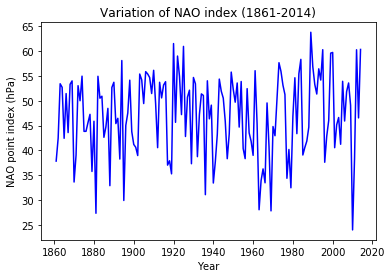

Total time: --- 3.75648593903 seconds ---


In [74]:
'''New version'''
import time as tm
import scipy as sp
from scipy import signal 
import netCDF4 as nc
import numpy as np 

start_time = tm.time()

a = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ws_interpolated2.nc")
b = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ps_interpolated.nc")
ps_inter = b.to_array()[0, :, :, :]
ds_ua850 = a.to_array()[0, :, 1:, :] #the 0th latitude gives nan values

#latss 65.68921234 - iceland 24 (old - 8)
#lonss 341.8875 - iceland 39 (old - 121)
#latss 37.78471054 - azores 24 (old - 18)
#lonss 334.35 - azores 22 (old - 119)

'''Defining useful terms'''
lat_ws_D = np.empty([154, 775])  
lat_ws_J = np.empty([154, 775])  
lat_ws_F = np.empty([154, 775])
winter_speeds = np.empty([154, 775, 128])

jet_strength = np.empty([154])
jet_latitude = np.empty([154])
NAO_index = np.empty([154])
header_param = "Year\t\tLatitude\tStrength\tNAO_index"

'''Winter mean NetCDF file'''
path = "/rds/general/user/ib719/home/UROP_2021/ws_winter.nc"
avg_ws = nc.Dataset(path, 'w', format = 'NETCDF4')
time = avg_ws.createDimension('time', 154)
lat = avg_ws.createDimension('lat', 775)
lon = avg_ws.createDimension('lon', 128)

times = avg_ws.createVariable('time', np.float32, ('time',))
lats = avg_ws.createVariable('lat', np.float32, ('lat',))
lons = avg_ws.createVariable('lon', np.float32, ('lon',))
value = avg_ws.createVariable('value', np.float32, ('time', 'lat', 'lon',))
value.units = 'm/s'
times[:] = np.arange(1861, 2015)
lats[:] = latss[1:]
lons[:] = ds_ws.lon[:]

lat_ws_D[:, :] = np.mean(ds_ua850[119:1967:12, :, :], axis = 2) #1967 because 1968 is December
lat_ws_J[:, :] = np.mean(ds_ua850[120:1968:12, :, :], axis = 2) #should be 154
lat_ws_F[:, :] = np.mean(ds_ua850[121:1968:12, :, :], axis = 2) #should be 154

for i in range(10, 164): # Number of years from 1861 to 2014 
    value[i-10, :, :] = np.mean(ds_ua850[(12*i-1):(12*i+2), :, :], axis = 0)
    azores_ps = ps_inter[(12*i-1):(12*i+2), 449, 119] # Azores DJF
    iceland_ps = ps_inter[(12*i-1):(12*i+2), 199, 121] # Iceland DJF
    NAO_index[i-10] = np.average(azores_ps - iceland_ps)/100 # Division by 100 to convert into hPa
    jet_strength[i-10] = np.average([max(lat_ws_D[i-10]), max(lat_ws_J[i-10]), max(lat_ws_F[i-10])])
    # 1 is added to the index because the first latitude in latss is not used in lat_ws_D
    jet_latitude[i-10] = np.average([latss[np.where(lat_ws_D[i-10] == max(lat_ws_D[i-10]))[0][0]+1], \
                                     latss[np.where(lat_ws_J[i-10] == max(lat_ws_J[i-10]))[0][0]+1], \
                                     latss[np.where(lat_ws_F[i-10] == max(lat_ws_F[i-10]))[0][0]+1]])
    
avg_ws.close()
    
params = np.column_stack([ds_ws.time[120:1957:12].dt.year, jet_latitude, jet_strength, NAO_index])
np.savetxt('parameters.txt', params, fmt = '%.5f', delimiter = '\t', header = header_param, comments = '')
print('Parameters are saved')

plt.xlabel('Year')
plt.ylabel('NAO point index (hPa)')
plt.title('Variation of NAO index (1861-2014)')
plt.plot(np.arange(1861, 2015), NAO_index, color = 'blue')
plt.show()

print("Total time: --- %s seconds ---" % (tm.time() - start_time))

In [80]:
""" Regression Analysis """
import time
import scipy as sp
from scipy import signal 
import netCDF4 as nc

start_time = time.time()
c = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ws_winter.nc")
ds_avgws = c.to_array()[0, :, :, :]
years, jet_latitude, jet_strength, NAO_index = np.loadtxt("parameters.txt", skiprows = 1, unpack = True)
jet_strength_de = signal.detrend(jet_strength)
jet_latitude_de = signal.detrend(jet_latitude)
NAO_index_de = signal.detrend(NAO_index)

''' Slopes Dataset '''
path = "/rds/general/user/ib719/home/UROP_2021/slopes.nc"
slopes = nc.Dataset(path, 'w', format = 'NETCDF4')
lat = slopes.createDimension('lat', 775)
lon = slopes.createDimension('lon', 128)

lats = slopes.createVariable('lat', np.float32, ('lat',))
lons = slopes.createVariable('lon', np.float32, ('lon',))
nao = slopes.createVariable('nao', np.float32, ('lat', 'lon',))
nao.units = 'm/s/hPa'
jet_lat = slopes.createVariable('jet_lat', np.float32, ('lat', 'lon',))
jet_lat.units = 'deg'
jet_str = slopes.createVariable('jet_str', np.float32, ('lat', 'lon',))
jet_str.units = 'm/s/deg'
lats[:] = latss[1:]
lons[:] = ds_ws.lon[:]

for j in range(0, 775):
    for k in range(0, 128):
        fit1 = np.polyfit(NAO_index_de, ds_avgws[:, j, k], 1)
        nao[j, k] = fit1[0]
        fit2 = np.polyfit(jet_latitude_de, ds_avgws[:, j, k], 1)
        jet_lat[j, k] = fit2[0]
        fit3 = np.polyfit(jet_strength_de, ds_avgws[:, j, k], 1)
        jet_lat[j, k] = fit3[0]
    if j % 50 == 0: 
        print("Calculating latitude #%d: --- %s seconds ---" % (j, tm.time() - start_time))
slopes.close()

print("Indices are saved")

'''Averaging ws_winter time series'''
path = "/rds/general/user/ib719/home/UROP_2021/ua850_contour.nc"
cont = nc.Dataset(path, 'w', format = 'NETCDF4')
lat = cont.createDimension('lat', 775)
lon = cont.createDimension('lon', 128)

lats = cont.createVariable('lat', np.float32, ('lat',))
lons = cont.createVariable('lon', np.float32, ('lon',))
value = cont.createVariable('value', np.float32, ('lat', 'lon',))
value.units = 'm/s'
lats[:] = latss[:1]
lons[:] = ds_ws.lon[:]

for j in range(0, 775):
    for k in range(0, 128):
        value[j, k] = np.average(ds_avgws.value[:, j, k])
    if j % 100 == 0: 
        print("Calculating latitude #%d: --- %s seconds ---" % (j, tm.time() - start_time))    
cont.close()

print("Speeds are time averaged")

print("--- %s seconds ---" % (time.time() - start_time))

Calculating latitude #0: --- 0.761624097824 seconds ---
Calculating latitude #50: --- 34.4089460373 seconds ---
Calculating latitude #100: --- 67.9677491188 seconds ---
Calculating latitude #150: --- 101.458049059 seconds ---
Calculating latitude #200: --- 134.956707001 seconds ---
Calculating latitude #250: --- 168.518666983 seconds ---
Calculating latitude #300: --- 201.96970892 seconds ---
Calculating latitude #350: --- 235.421839952 seconds ---
Calculating latitude #400: --- 268.910237074 seconds ---
Calculating latitude #450: --- 302.463680983 seconds ---
Calculating latitude #500: --- 335.944549084 seconds ---
Calculating latitude #550: --- 369.440392017 seconds ---
Calculating latitude #600: --- 402.98199296 seconds ---
Calculating latitude #650: --- 436.502059937 seconds ---


KeyboardInterrupt: 

In [83]:
b = [[[ 0.73767766,  0.90666081],[ 0.84188105,  0.67104253]],[[ 0.4629632,   0.68382201],[ 0.84119681,  0.19712657]],[[ 0.7680008,  0.85360126], [ 0.94593916,  0.06555792]]]


[[[ 0.73767766  0.90666081]
  [ 0.84188105  0.67104253]]

 [[ 0.4629632   0.68382201]
  [ 0.84119681  0.19712657]]

 [[ 0.7680008   0.85360126]
  [ 0.94593916  0.06555792]]]


In [ ]:
'''Plotting results'''
import os
#conda install basemap
os.environ["PROJ_LIB"] = "/rds/general/user/ib719/home/anaconda3/envs/test1/share/proj"
from mpl_toolkits.basemap import Basemap
ds_ws = xr.open_dataset("/rds/general/user/ib719/home/UROP_2021/ua850_contour.nc")

map = Basemap(projection='cyl',llcrnrlon=-100.,llcrnrlat=1.39,urcrnrlon=50.0,urcrnrlat=90.,resolution='l') 
# projection, lat/lon extents and resolution of polygons to draw
# resolutions: c - crude, l - low, i - intermediate, h - high, f - full

map.drawcoastlines()
map.drawparallels(np.arange(10, 81, 10), labels = [1,0,0,0])
map.drawmeridians(np.arange(-90, 46, 45), labels = [0,0,0,1])
ua = np.array(ds_ws.value)
clevs = np.arange(0, 10, 3)
x, y = np.meshgrid(lonss, latss)

#cs = map.contour(x, y, np.roll(ua[:, :], shift = -1600, axis = 1), clevs, colour = 'b') #should be with x -180?
cs = map.contour(x, y, ua[:, :], clevs, colour = 'b', latlon = 1)
plt.clabel(cs, fontsize=6, inline=2)


In [59]:
a = [[1.52, 2.13, 3.13], [4.2542, 5.00, 6.777], [3, 5, 6], [8, 6, 9]]
a = np.transpose(a)
np.savetxt('data.txt', a, fmt = '%.2f', delimiter = '\t', header = "HDA\t\tZeff\tchicha\treal", comments = '')

In [26]:
"""Proof that the coordinates are not spreaded equally (due to spherical geometry?)"""
b = np.array([87.8638  ,  85.096527,  82.312912,  79.525604,  76.7369  ,  73.947517,
        71.157753,  68.36776 ,  65.577606,  62.787354,  59.997021,  57.206631,
        54.416199,  51.625732,  48.835239,  46.044727,  43.254196,  40.46365 ,
        37.673088,  34.882523,  32.091946,  29.301359,  26.510769,  23.720175,
        20.929575,  18.138971,  15.348365,  12.557756,   9.767145,   6.976533,
         4.185921,   1.395307,  -1.395307,  -4.185921,  -6.976533,  -9.767145,
       -12.557756, -15.348365, -18.138971, -20.929575, -23.720175, -26.510769,
       -29.301359, -32.091946, -34.882523, -37.673088, -40.46365 , -43.254196,
       -46.044727, -48.835239, -51.625732, -54.416199, -57.206631, -59.997021,
       -62.787354, -65.577606, -68.36776 , -71.157753, -73.947517, -76.7369  ,
       -79.525604, -82.312912, -85.096527, -87.8638 ])

a = np.linspace(87.8638, -87.8638, 64)
print(a-b)

d = np.linspace(87.8638, 85.096527, 26)
print(d[10:12])

c = np.empty([31*25])
for i in range(0, 31):
    c[(i*25):(i+1)*25] = np.linspace(ds_ws.lat[i], ds_ws.lat[i+1], 26)[0:-1]
c = np.append(c, ds_ws.lat[31])
#print(c)

[ 0.         -0.02205398 -0.02776597 -0.02978495 -0.03040794 -0.03035192
 -0.0299149  -0.02924889 -0.02842187 -0.02749686 -0.02649084 -0.02542783
 -0.02432281 -0.02318279 -0.02201678 -0.02083176 -0.01962775 -0.01840873
 -0.01717371 -0.0159357  -0.01468568 -0.01342567 -0.01216265 -0.01089563
 -0.00962262 -0.0083456  -0.00706659 -0.00578457 -0.00450056 -0.00321554
 -0.00193052 -0.00064351  0.00064351  0.00193052  0.00321554  0.00450056
  0.00578457  0.00706659  0.0083456   0.00962262  0.01089563  0.01216265
  0.01342567  0.01468568  0.0159357   0.01717371  0.01840873  0.01962775
  0.02083176  0.02201678  0.02318279  0.02432281  0.02542783  0.02649084
  0.02749686  0.02842187  0.02924889  0.0299149   0.03035192  0.03040794
  0.02978495  0.02776597  0.02205398  0.        ]
[ 86.7568908   86.64619988]
